In [218]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np

import random

In [219]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [220]:
# ==============================
# Preparing the dataset
# ==============================

In [221]:
#generating data
data_1 = np.array([random.choice(range(-999, 1000)) for  _ in range(10000)])
data_2 = np.array([random.choice(range(-999, 1000)) for  _ in range(10000)])
X = np.hstack([data_1.reshape(-1,1), data_2.reshape(-1,1)])
sum_signs = np.sign(data_1 + data_2)

Y = np.zeros((X.shape[0], 3))

for i in range(sum_signs.size):
    if sum_signs[i] == -1:
        Y[i] = np.array([1,0,0])
    if sum_signs[i] == 0:
        Y[i] = np.array([0,1,0])
    if sum_signs[i] == 1:
        Y[i] = np.array([0,0,1])

In [222]:
Y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [223]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.x = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(Y,dtype=torch.float32)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [224]:
train_dataset = Dataset(X[:8000,:], Y[:8000])
test_dataset = Dataset(X[8000:,:], Y[8000:])

In [225]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

In [226]:
# ==============================
# Defining the dense NN
# ==============================

In [227]:
class DenseNN(nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [228]:
model = DenseNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
summary(model, input_size=(1, 2), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
DenseNN                                  [1, 3]                    --
├─Linear: 1-1                            [1, 64]                   192
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 3]                    195
Total params: 4,547
Trainable params: 4,547
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [229]:
epochs = 100
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0) #inputs.size is 64

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 0.7266
Epoch 2/100, Loss: 0.1214
Epoch 3/100, Loss: 0.1323
Epoch 4/100, Loss: 0.1158
Epoch 5/100, Loss: 0.0927
Epoch 6/100, Loss: 0.1265
Epoch 7/100, Loss: 0.1831
Epoch 8/100, Loss: 0.0584
Epoch 9/100, Loss: 0.0986
Epoch 10/100, Loss: 0.0607
Epoch 11/100, Loss: 0.0695
Epoch 12/100, Loss: 0.0471
Epoch 13/100, Loss: 0.0678
Epoch 14/100, Loss: 0.0618
Epoch 15/100, Loss: 0.0711
Epoch 16/100, Loss: 0.0529
Epoch 17/100, Loss: 0.0375
Epoch 18/100, Loss: 0.0356
Epoch 19/100, Loss: 0.0324
Epoch 20/100, Loss: 0.0358
Epoch 21/100, Loss: 0.0367
Epoch 22/100, Loss: 0.0377
Epoch 23/100, Loss: 0.0425
Epoch 24/100, Loss: 0.0272
Epoch 25/100, Loss: 0.0341
Epoch 26/100, Loss: 0.0261
Epoch 27/100, Loss: 0.0197
Epoch 28/100, Loss: 0.0252
Epoch 29/100, Loss: 0.0193
Epoch 30/100, Loss: 0.0240
Epoch 31/100, Loss: 0.0212
Epoch 32/100, Loss: 0.0171
Epoch 33/100, Loss: 0.0204
Epoch 34/100, Loss: 0.0174
Epoch 35/100, Loss: 0.0168
Epoch 36/100, Loss: 0.0158
Epoch 37/100, Loss: 0.0147
Epoch 38/1

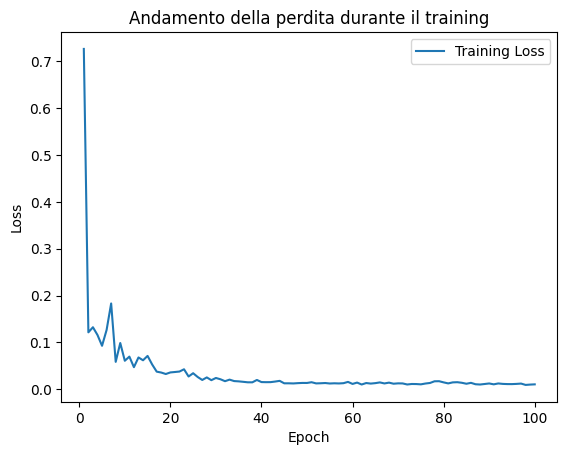

In [230]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Andamento della perdita durante il training')
plt.legend()
plt.savefig('relazione/immagini/training_loss2_mod.png', dpi = 300)

In [231]:
model.eval()
correct = 0
total = 0
misclassified = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_class = torch.argmax(labels,axis=1)
        total += labels.size(0)
        correct += (predicted == true_class).sum().item()
        
        for i in range(inputs.size(0)):
            if predicted[i] != true_class[i]:
                misclassified.append((inputs[i].cpu(), predicted[i].item(), true_class[i].item()))
        
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')
print(f'{correct} out of {total}')

Accuracy: 99.85%
1997 out of 2000


In [232]:
misclassified

[(tensor([-502.,  506.]), 0, 2),
 (tensor([-803.,  810.]), 0, 2),
 (tensor([ 248., -249.]), 2, 0)]